In [ ]:
suppressMessages(require(ggplot2))
suppressMessages(require(data.table))
suppressMessages(require(gplots))
suppressMessages(require(Seurat))
suppressMessages(require(Matrix))
suppressMessages(require(reshape))
suppressMessages(require(scales))
suppressMessages(require(feather))
suppressMessages(require(ggpubr))
source("VDJ_ploting_suite.R")
source("VDJ_function_pack.R")

In [2]:
DICE=readDICE()

In [3]:
DICE[[1]][1:5,1:5]

,1,2,3,4,5
ENSG00000000003.10,0.6520858,0.6485091,0.6432881,0.5850102,0.5567957
ENSG00000000005.5,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
ENSG00000000419.8,101.9027851,93.7444707,89.5815568,88.6190966,86.1562550
ENSG00000000457.9,56.2477033,53.6127964,52.6253703,52.5552798,51.7036566
ENSG00000000460.12,12.0546116,11.9703768,11.8331535,11.8109522,11.5378537


In [2]:
load("180607_RUVscale_R2.Rdata")
#load("abgdTcell_labeling.Rdata")

In [6]:
ExpressionMat_magic=readRDS("180607_RUVscale_magic.rds")
ExpressionMat_by_gp=readRDS(file="ExpressionMat_by_gp.Rds")

lsnofun()

[1] "abgdTcells"          "abTcells"            "BCR_annoation"      
 [4] "BCR_annoation_w"     "cell_assignment_gps" "ExpressionMat_by_gp"
 [7] "ExpressionMat_magic" "Exp_Seurat"          "gdTcells"           
[10] "HVG"                 "patient_type"        "sample_list"        
[13] "t2g"                 "taggene_hk"          "taggene_mt"         
[16] "TCR_annoation"       "TCR_annoation_w"     "tissue_type"

In [7]:
sample_cell_num=table(Exp_Seurat@meta.data$sample_gp)
names(sample_cell_num)=sample_list[as.numeric(names(sample_cell_num))]
saveRDS(sample_cell_num,file="sample_cell_num.rds")

### test scanoR

In [3]:
Mtx="scanoR_test.feather"
meta="scanoR_test_metadata.feather"
out="scanoR_test_out.feather"

In [4]:
R2norm=t(apply(Exp_Seurat@raw.data,2,function(x){x/sqrt(sum(x^2))*100}))
write_feather(as.data.frame(R2norm), Mtx)
write_feather(Exp_Seurat@meta.data[,c("nGene","nUMI","sample_gp")], meta)

In [5]:
#Shell:
paste0("source activate py35_scanorama")
paste0("python ~/pycharmProject/scanoR/scanoR/scanoR.py --mtx ",getwd(),"/",Mtx," --meta ",getwd(),"/",meta," --out ",getwd(),"/",out)

[1] "source activate py35_scanorama"

[1] "python ~/pycharmProject/scanoR/scanoR/scanoR.py --mtx /home/ahe/Analysis/201801_JohnVDJ/analysis/scanoR_test.feather --meta /home/ahe/Analysis/201801_JohnVDJ/analysis/scanoR_test_metadata.feather --out /home/ahe/Analysis/201801_JohnVDJ/analysis/scanoR_test_out.feather"

In [ ]:
ExpressionMat_MNN = data.matrix(read_feather(out))

Exp_Seurat_MNN=Exp_Seurat
Exp_Seurat_MNN@data=apply(Exp_Seurat@raw.data,2,function(x){x/sqrt(sum(x^2))})
Exp_Seurat_MNN@scale.data=t(ExpressionMat_MNN)
Exp_Seurat_MNN@scale.data=Exp_Seurat_MNN@scale.data[match(rownames(Exp_Seurat_MNN@data),rownames(Exp_Seurat_MNN@scale.data)),]
Exp_Seurat_MNN <- FindVariableGenes(Exp_Seurat_MNN, do.plot = F)
HVG <- head(rownames(Exp_Seurat_MNN@hvg.info), 5000)
Exp_Seurat_MNN <- RunPCA(object = Exp_Seurat_MNN,pc.genes = HVG[1:3000], pcs.compute = 100,do.print = F)
#add a small perturbation
perturb=rnorm(ncol(Exp_Seurat_MNN@data),mean=0,sd=min(abs(Exp_Seurat_MNN@dr$pca@cell.embeddings))/10)
Exp_Seurat_MNN@dr$pca@cell.embeddings[,1]=Exp_Seurat_MNN@dr$pca@cell.embeddings[,1]+perturb
rtsne_out=Rtsne::Rtsne(Exp_Seurat_MNN@dr$pca@cell.embeddings[,1:25],pca=F)

Exp_Seurat_MNN@dr$tsne@cell.embeddings=rtsne_out$Y
Exp_Seurat_MNN=umap_seurat(Exp_Seurat_MNN,pca_dim=25)

## cell type analysis

In [3]:
#re cluster 
#not necessary
#Exp_Seurat <- FindClusters(object = Exp_Seurat, resolution = 1.2, print.output = F, reuse.SNN = TRUE)

1 singletons identified. 24 final clusters.


In [7]:
#filter unwanted groups
ExpressionMat_magic=ExpressionMat_magic[!Exp_Seurat@ident %in% c("20","21"),]
Exp_Seurat = filter_ident(Exp_Seurat,c("20","21"))

In [24]:
require(scMCA)
rownames(Exp_Seurat@data)=firstup(rownames(Exp_Seurat@data))

mca_result <- scMCA(scdata = Exp_Seurat@data, numbers_plot = 3)
saveRDS(mca_result,file="mca_result_filteredUnwatedGps.Rds")
rownames(Exp_Seurat@data)=toupper(rownames(Exp_Seurat@data))

Loading required package: scMCA
Warning message:
“replacing previous import ‘shiny::dataTableOutput’ by ‘DT::dataTableOutput’ when loading ‘scMCA’”Warning message:
“replacing previous import ‘shiny::renderDataTable’ by ‘DT::renderDataTable’ when loading ‘scMCA’”

In [ ]:
mca_result=readRDS("mca_result_filteredUnwatedGps.Rds")
new_mca_result=scMCA_celltype_conversion_filtering("scMCA_celltype_conversion.txt",mca_result,min_cellnumber = 10)

In [2]:
#find marker gene, Seurat
#marker_genes=FindAllMarkers(object = Exp_Seurat, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25)
#saveRDS(marker_genes, "markerGenes_180607_RUVscale.rds")
marker_genes=readRDS("markerGenes_180607_RUVscale.rds")

In [3]:
#cell cyle score
# not necessary
Exp_Seurat=cellcycle_assigning(Exp_Seurat,cycle_gene_list="~/Analysis/genomeFiles/regev_lab_cell_cycle_genes.txt")

In [8]:
celltype_assignment_df=data.frame(cluster=c("17,16","8,2","13,5","6,0","7,10","11,1","3","18,12,9,19","4,14,15"), #,"21,20"
                                  celltype=c("Naive_B","Memory_B","Plasma","NKT","CD8","CD4","gdT","NK","M/DC"), #,"unknown"
                                  stringsAsFactors=F)

celltype_assignment_expanded=cellTypeDF_processing(celltype_assignment_df)

celltype_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),celltype_assignment_expanded$cluster,celltype_assignment_expanded$celltype)
subcelltype_assignment=gp_name_replacing(as.character(Exp_Seurat@ident),celltype_assignment_expanded$cluster,celltype_assignment_expanded$subcelltype)
majorcelltype_assignment=gp_name_replacing(celltype_assignment,
                                           c("Naive_B","Memory_B","Plasma","NKT","CD8","CD4","gdT"),
                                           c("B","B","B","T","T","T","T"))

In [8]:
#contrust matrix, each row is a state
ExpressionMat_by_gp=cbind(Exp_Seurat@ident,2^t(Exp_Seurat@data))
colnames(ExpressionMat_by_gp)[1]="states"
tagV=c("TRAV","TRAC","TRBV","TRBC","TRGV","TRGC","TRDV","TRDC",
       "IGHV","IGHG","IGHA","IGHD","IGHM","IGHE","IGLV","IGLL","IGKV","IGLC","IGKC")
togetrid=c("IGHMBP2")

tagvmat=t(Exp_Seurat@data)[,1:length(tagV)]
colnames(tagvmat)=tagV

for(i in 1:length(tagV)){
    tagG=grep(paste0("^",tagV[i]),colnames(ExpressionMat_by_gp))
    tagG=setdiff(tagG,togetrid)
    if(length(tagG)==0){
        next
    }
    tmp=ExpressionMat_by_gp[,tagG]
    if(!is.null(ncol(tmp))){
        tagvmat=rowSums(tmp)
    }
}
ExpressionMat_by_gp=cbind(ExpressionMat_by_gp,tagvmat)

ExpressionMat_by_gp=data.table(ExpressionMat_by_gp)
ExpressionMat_by_gp=ExpressionMat_by_gp[,lapply(.SD, mean), by=states]
ExpressionMat_by_gp=ExpressionMat_by_gp[order(ExpressionMat_by_gp$states)]
ExpressionMat_by_gp[,states:=NULL]
ExpressionMat_by_gp=data.frame(ExpressionMat_by_gp)
colnames(ExpressionMat_by_gp)=gsub("\\.","-",colnames(ExpressionMat_by_gp))
ExpressionMat_by_gp=log2(ExpressionMat_by_gp)
rownames(ExpressionMat_by_gp)=paste0("cluster_",levels(Exp_Seurat@ident))
write.table(t(ExpressionMat_by_gp),"mediam_gene_expression.tsv",sep="\t",col.names=T,row.names=T,quote=F)
saveRDS(ExpressionMat_by_gp,file="ExpressionMat_by_gp_filteredUnwatedGps.Rds")

In [9]:
ExpressionMat_by_gp=readRDS("ExpressionMat_by_gp_filteredUnwatedGps.Rds")

taggene=c("Cd3d","Cd3e","Cd3g","CD8A","CD8B","CD4","NCAM1","TBX21","IFNG","GATA3",
          "IL17A","RORC","CXCR5","BCL6","PDCD1","FOXP3","FCER2","ZBTB7B","RUNX3",
          "CD14","ITGAM","CEBPA","CEBPB","SPI1","FLT3","ITGAX","ZBTB46","CEACAM8","ZBTB10",
          "IL3RA","CLEC4C","NRP1","NKG7","KLRC1","KLRC2","KLRC3","KLRB1","Ly6G6D","Adgre1",
          "CD19","SDC1","MS4A1","CD38","CD27","TNFRSF13C","CD84","CD86","CD24",
          "TRAV","TRAC","TRBV","TRBC","TRGV","TRGC","TRDV","TRDC","CR2","CD22",
          "IGHV","IGHG","IGHA","IGHD","IGHM","IGHE","IGLV","IGLL","IGKV","IGLC","IGKC")

#taggene=c("Cd3d","Cd3e","Cd3g","CD8A","CD8B","CD4","ZBTB7B","RUNX3","TBX21","IFNG","GATA3","TRAV","TRAC","TRBV","TRBC","TRGV","TRGC","TRDV","TRDC",
#          "IL17A","RORC","CXCR5","BCL6","PDCD1","FOXP3",'KLRG1',"BATF","IRF4","CD44","SELL","CCR7","TBX21")

taggene=toupper(taggene)
tagExpressionNormed=ExpressionMat_by_gp[,which(colnames(ExpressionMat_by_gp) %in% taggene)]
#tagExpressionNormed=tagExpressionNormed[,order(colnames(tagExpressionNormed))]
taggene[!taggene %in% colnames(ExpressionMat_by_gp)]

rownames(tagExpressionNormed)=celltype_assignment_expanded$subcelltype[order(as.numeric(celltype_assignment_expanded$cluster))]

[1] "IL17A"   "RORC"    "FLT3"    "ZBTB46"  "CEACAM8" "CLEC4C"  "NRP1"   
 [8] "KLRC2"   "LY6G6D"  "TRAV"    "TRBV"    "TRBC"    "TRGV"    "TRGC"   
[15] "TRDV"    "IGHV"    "IGHG"    "IGHA"    "IGHE"    "IGLV"    "IGLL"   
[22] "IGKV"    "IGLC"

In [16]:
#options(repr.plot.width=10, repr.plot.height=8)
pdf("celltype_markergene_heatmap.pdf",width=10,height=8)
col2=rev(RColorBrewer::brewer.pal(9,"RdBu"))
heatmap.2(scale(tagExpressionNormed),col=colorRampPalette(col2),
          trace="none",density.info="none",dendrogram='none',Colv=T,Rowv=T,notecol="black",key=T,lhei=c(1,5),lwid=c(1,5),
          main=paste0("cell assignment vs. marker gene"),key.title="",key.xlab="",margins=c(5,6))
#,labRow=celltype_assignment_expanded$subcelltype[order(as.numeric(celltype_assignment_expanded$cluster))]
dev.off()

png 
  2

In [10]:
#require(repr)
#options(repr.plot.width=18, repr.plot.height=15)
pdf("TSNE_mito.pdf",width=18,height=15)
par(mfrow=c(3,3))
plotByGroup(Exp_Seurat,sample_list[Exp_Seurat@meta.data$sample_gp],Group_type=sample_list,Addtext=F,main="Batch")
plotByGroup(Exp_Seurat,tissue_type[Exp_Seurat@meta.data$tissue_assignment],Group_type=tissue_type,Addtext=F,main="Tissue")
plotByGroup(Exp_Seurat,patient_type[Exp_Seurat@meta.data$patient_assignment],Group_type=patient_type,Addtext=F,main="Patient")
plotByGroup(Exp_Seurat,Exp_Seurat@meta.data$cell_assignment,Addtext=F,main="BT assigned by VDJ")
plotByGroup(Exp_Seurat,new_mca_result$scMCA,Group_type = new_mca_result$celltype_list,Addtext=T,main="scMCA")
plotByGroup(Exp_Seurat,majorcelltype_assignment,Group_type = c("B","T","NK","M/DC"),Addtext=T,main="manual assignment\nmajor")
plotByGroup(Exp_Seurat,celltype_assignment,Group_type = unique(celltype_assignment_expanded$celltype),Addtext=T,main="manual assignment")
plotByGroup(Exp_Seurat,subcelltype_assignment,Group_type = celltype_assignment_expanded$subcelltype,Addtext=T,main="manual assignment")
plotByGroup(Exp_Seurat,c("healthy","disease")[Exp_Seurat@meta.data$disease_assignment],Group_type = c("disease","healthy"),Addtext=F,main="disease")
dev.off()

png 
  2

In [7]:
pdf("TSNE_mito_byManual.pdf",width=16,height=16)
par(mfrow=c(4,4))
plotByGroup_1by1(Exp_Seurat,Group_assignment=subcelltype_assignment,Group_type = celltype_assignment_expanded$subcelltype)
dev.off()

pdf("TSNE_mito_bySCMCA.pdf",width=16,height=16)
par(mfrow=c(4,4))
plotByGroup_1by1(Exp_Seurat,Group_assignment = new_mca_result$scMCA,Group_type = new_mca_result$celltype_list)
dev.off()

png 
  2

png 
  2

#### cell percentage of each cell type in tissue/patient/disease_status

In [19]:
tmp=table(majorcelltype_assignment,Exp_Seurat@meta.data$sample_gp)
tmp_rownames=rownames(tmp)
colnames(tmp)=sample_list[as.numeric(colnames(tmp))]
tmp=data.table(as.data.frame.matrix(tmp))
tmp_percent_by_all=data.table(apply(tmp,2,function(x){x/sum(x)}))
tmp$majorcelltype=tmp_rownames
tmp_percent_by_all$majorcelltype=tmp_rownames

tmp=melt(tmp, id.vars = "majorcelltype",measure.vars = setdiff(colnames(tmp),"majorcelltype"),
         variable.name="batch",value.name="count")
tmp_percent_by_all=melt(tmp_percent_by_all, id.vars = "majorcelltype",measure.vars = setdiff(colnames(tmp_percent_by_all),"majorcelltype"),
         variable.name="batch",value.name="percent")
tmp$percent=tmp_percent_by_all$percent
tmp$patient=gsub("_.*","",tmp$batch)
tmp$tissue=gsub("^.*_","",tmp$batch)
tmp$disease_status=gp_name_replacing(substr(tmp$batch, 1, 1),c("C","U"),c("Healthy","IBD"))
tmp=data.frame(tmp)

pdf("major cell type distribution.pdf",width=12,height=5)
coltouse=RColorBrewer::brewer.pal(4,"Set1")
#options(repr.plot.width=12, repr.plot.height=5)
ggplot() +
geom_bar(aes(y = count, x = patient, fill = factor(majorcelltype,levels=c("B","T","NK","M/DC"))), data = tmp,stat="identity",position = "stack") +
scale_y_continuous() +
theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
facet_grid( ~ tissue,scales="free_x", space="free_x") + 
ggtitle("") + labs(y = "count of cells in given batch",fill='major cell types') + 
scale_fill_manual("legend", values = coltouse)

ggplot() +
geom_bar(aes(y = count, x = patient, fill = factor(majorcelltype,levels=c("B","T","NK","M/DC"))), data = tmp,stat="identity",position = "fill") +
scale_y_continuous(labels = percent_format()) +
theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
facet_grid( ~ tissue,scales="free_x", space="free_x") + 
ggtitle("") + labs(y = "pecentage of cells in given batch",fill='major cell types') + 
scale_fill_manual("legend", values = coltouse)
dev.off()

# define the summary function
f <- function(x) {
  r <- quantile(x, probs = c(0.1, 0.25, 0.5, 0.75, 0.9))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

o <- function(x) {
  subset(x, x < quantile(x)[2] | quantile(x)[4] < x)
}

coltouse=RColorBrewer::brewer.pal(3,"Set1")

options(warn=-1) #turn off warning
pdf(paste0("healthy vs IBD in major cell type.pdf"),width=8,height=14)
coltouse=RColorBrewer::brewer.pal(4,"Set1")
ggplot(tmp, aes(x=disease_status, y=count, fill=disease_status)) + 
facet_wrap( ~ tissue + majorcelltype,scales="free",nrow=3,labeller = label_wrap_gen(multi_line=FALSE)) + 
stat_summary(fun.data=f, geom="boxplot") +
stat_summary(fun.y=o, geom="point") +
labs(y = "count of cells in given batch") + ggtitle("count") +
stat_compare_means(label.x = 1.5,comparisons = list(c("Healthy","IBD"))) + #aes(label = ..p.signif..),
scale_fill_manual(values=coltouse[2:1])

coltouse=RColorBrewer::brewer.pal(4,"Set1")
ggplot(tmp, aes(x=disease_status, y=percent, fill=disease_status)) + 
facet_wrap( ~ tissue + majorcelltype,scales="free",nrow=3,labeller = label_wrap_gen(multi_line=FALSE)) + 
stat_summary(fun.data=f, geom="boxplot") +
stat_summary(fun.y=o, geom="point") +
labs(y = "pecentage of cells in given batch") + ggtitle("percent by cell type") +
stat_compare_means(label.x = 1.5,comparisons = list(c("Healthy","IBD"))) + #aes(label = ..p.signif..),
scale_fill_manual(values=coltouse[2:1])

dev.off()

png 
  2

png 
  2

In [9]:
#options(repr.plot.width=6, repr.plot.height=8)
col2=rev(RColorBrewer::brewer.pal(9,"RdBu"))

clusterVsPatient=table(majorcelltype_assignment,Exp_Seurat@meta.data$patient_assignment)
colnames(clusterVsPatient)=patient_type
clusterVsPatient=t(apply(clusterVsPatient,1,function(x){x/sum(x)}))

clusterVsTissue=table(majorcelltype_assignment,Exp_Seurat@meta.data$tissue_assignment)
colnames(clusterVsTissue)=tissue_type
clusterVsTissue=t(apply(clusterVsTissue,1,function(x){x/sum(x)}))

clusterVsDisease=table(majorcelltype_assignment,Exp_Seurat@meta.data$disease_assignment)
colnames(clusterVsDisease)=c("healthy","disease")
clusterVsDisease=t(apply(clusterVsDisease,1,function(x){x/sum(x)}))

pdf("celltypeVsPatient_heatmap.pdf",width=9,height=6)
heatmap.2(clusterVsPatient,col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(10,10),trace="none",density.info="none",dendrogram='col',Colv=T,Rowv=F,
          notecol="black",key=F)
dev.off()

pdf("celltypeVsTissue_heatmap.pdf",width=3.5,height=6)
heatmap.2(clusterVsTissue,col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(10,10),trace="none",density.info="none",dendrogram='col',Colv=T,Rowv=F,
          notecol="black",key=F)
dev.off()

pdf("celltypeVsDisease_heatmap.pdf",width=3,height=6)
heatmap.2(clusterVsDisease,col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(10,10),trace="none",density.info="none",dendrogram='col',Colv=T,Rowv=F,
          notecol="black",key=F)
dev.off()


#how well groups compare to BT assignment
clusterVsBTCR=table(majorcelltype_assignment,Exp_Seurat@meta.data$cell_assignment)
clusterVsBTCR_byrow=t(apply(clusterVsBTCR,1,function(x){x/sum(x)}))
clusterVsBTCR_bycol=apply(clusterVsBTCR,2,function(x){x/sum(x)})

pdf("celltypeVsBTCR_heatmap.pdf",width=3.5,height=6)
heatmap.2(clusterVsBTCR_bycol,col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(15,10),trace="none",density.info="none",dendrogram='col',Colv=T,Rowv=F,
          notecol="black",key=F,cellnote=clusterVsBTCR)
heatmap.2(clusterVsBTCR_byrow,col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(15,10),trace="none",density.info="none",dendrogram='col',Colv=T,Rowv=F,
          notecol="black",key=F,cellnote=clusterVsBTCR)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### gene exp plot

In [12]:
#contrust matrix, each row is a state
tagV=c("TRAV","TRAC","TRBV","TRBC","TRGV","TRGC","TRDV","TRDC",
       "IGHV","IGHG","IGHA","IGHD","IGHM","IGHE","IGLV","IGLL","IGKV","IGLC","IGKC")
togetrid=c("IGHMBP2")
tagvmat=ExpressionMat_magic[,1:length(tagV)]
colnames(tagvmat)=tagV

for(i in 1:length(tagV)){
    tagG=grep(paste0("^",tagV[i]),colnames(ExpressionMat_magic))
    tagG=setdiff(tagG,togetrid)
    if(length(tagG)==0){
        next
    }
    tmp=ExpressionMat_magic[,tagG]
    if(!is.null(ncol(tmp))){
        tagvmat=rowMeans(tmp)
    }
}
ExpressionMat_magic=cbind(ExpressionMat_magic,tagvmat)

In [ ]:
taggene=c("Cd3d","Cd4","Cd8a","Cd19","MS4A1","Cd14","Itgax","Itgam","Cd68","FCGR3A","Ncam1","Foxp3","RORC","Sell","Il2ra","Notch1",
          "Zeb2","Itga4","Cxcr3","Foxo1","S1pr1","Lef1","Zfp683","Hobit","Id3","Ezh2","Klrg1","Cd69","Prdm1","S1pr4","Ifng","Klf2",
          "Gzmb","S1pr5","Eomes","Tcf7","Itgae","Tbx21","Ccr7","Irf4","Itga1","Id2","AHR","BATF","Il7r","Myc","Nr4a1","Litaf",
          "Bcl6","Malat1","Xbp1","KLRB1","CD34","LY6G6D")

taggene=toupper(taggene)
tagExpressionNormed=ExpressionMat_magic[,which(colnames(ExpressionMat_magic) %in% taggene)]
tagExpressionNormed=tagExpressionNormed[,order(colnames(tagExpressionNormed))]
colnames(tagExpressionNormed)
taggene[!taggene %in% colnames(ExpressionMat_magic)]

In [13]:
taggene=c("Cd3d","Cd3e","Cd3g","CD8A","CD8B","CD4","NCAM1","TBX21","IFNG","GATA3",
          "IL17A","RORC","CXCR5","BCL6","PDCD1","FOXP3","FCER2",
          "CD14","ITGAM","CEBPA","CEBPB","SPI1","FLT3","ITGAX","ZBTB46","CEACAM8","ZBTB10",
          "IL3RA","CLEC4C","NRP1","NKG7","KLRC1","KLRC2","KLRC3","KLRB1","Ly6G6D","Adgre1",
          "CD19","SDC1","MS4A1","CD38","CD27","TNFRSF13C","CD84","CD86","CD24",
          "TRAV","TRAC","TRBV","TRBC","TRGV","TRGC","TRDV","TRDC","CR2","CD22",
          "IGHV","IGHG","IGHA","IGHD","IGHM","IGHE","IGLV","IGLL","IGKV","IGLC","IGKC")

taggene=toupper(taggene)
tagExpressionNormed=ExpressionMat_magic[,which(colnames(ExpressionMat_magic) %in% taggene)]
tagExpressionNormed=tagExpressionNormed[,order(colnames(tagExpressionNormed))]
colnames(tagExpressionNormed)
taggene[!taggene %in% colnames(ExpressionMat_magic)]

[1] "BCL6"      "CD14"      "CD19"      "CD22"      "CD24"      "CD27"     
 [7] "CD38"      "CD3D"      "CD3E"      "CD3G"      "CD4"       "CD84"     
[13] "CD8A"      "CD8B"      "CEBPB"     "CR2"       "CXCR5"     "FCER2"    
[19] "FOXP3"     "GATA3"     "IFNG"      "IGHA"      "IGHD"      "IGHD"     
[25] "IGHG"      "IGHM"      "IGHM"      "IGHV"      "IGKC"      "IGKC"     
[31] "IGKV"      "IGLC"      "IGLL"      "IGLV"      "IL3RA"     "ITGAM"    
[37] "ITGAX"     "KLRB1"     "KLRC1"     "KLRC3"     "MS4A1"     "NCAM1"    
[43] "NKG7"      "PDCD1"     "SDC1"      "SPI1"      "TBX21"     "TNFRSF13C"
[49] "TRAC"      "TRAC"      "TRAV"      "TRBC"      "TRBV"      "TRDC"     
[55] "TRDC"      "TRDV"      "TRGC"      "TRGV"      "ZBTB10"

[1] "IL17A"   "RORC"    "CEBPA"   "FLT3"    "ZBTB46"  "CEACAM8" "CLEC4C" 
 [8] "NRP1"    "KLRC2"   "LY6G6D"  "ADGRE1"  "CD86"    "IGHE"

In [14]:
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
selected=sample(1:nrow(tagExpressionNormed),2000)

pdf(paste0("per gene mito TSNE_magic.pdf"),width=22,height=15)
par(mfrow=c(4,6))
for(i in 1:ncol(tagExpressionNormed)){
    currentid=colnames(tagExpressionNormed)[i]
    currentg=taggene[which(taggene==currentid)]
    #calculate breaks
    lowerbound=sort(tagExpressionNormed[selected,i])[round(length(selected)/33)]
    upperbound=sort(tagExpressionNormed[selected,i])[round(length(selected)/33*32)]
    if(upperbound!=lowerbound){
        breaks=c(min(tagExpressionNormed[selected,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[selected,i])+1)
        cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[selected,i],breaks = breaks, include.lowest=TRUE))]
    }else{
        breaks=c(min(tagExpressionNormed[selected,i])-1,max(tagExpressionNormed[selected,i])/2,max(tagExpressionNormed[selected,i]))
        cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[selected,i],breaks = breaks, include.lowest=TRUE))]
    }
    plot(Exp_Seurat@dr$tsne@cell.embeddings[selected,],pch=19,cex=0.35,col=cols,main=currentg)  
}

dev.off()

png 
  2

### associate the GWAS IBD gene with the scRNA

In [23]:
taggene=c("ACSL6","ADA","ADAM30","ADCY3","ADCY7","AHSA2","APOBEC3G","ARHGAP30","ARPC2","ATF4","ATG16L1","BRE","BSN","C10orf58",
          "C11orf9","C1orf53","C2orf74","CALM3","CARD11","CARD9","CCDC116","CCDC88B","CCL11","CCL13","CCL2","CCR6","CD226",
          "CD244","CD40,MMP9,PLTP","CD48","CD5","CD6","CEBPB","CEBPG","CEP250","CISD1","CNTF","CPEB4","CREB5","CREM","CRTC3",
          "CSF2","CTDSP1","CTSW","CTSZ","CXCL1","CXCL2","CXCL3","CXCL5","CXCL6","CXCR1","CXCR2","CXCR5","DAP","DBP","DCLRE1B",
          "DLD","DNMT3B","DOK3","EIF3C","EPO","ERAP1","ERAP2","F11R","FADS1","FADS2","FAIM3","FAM55A","FAM55D","FASLG","FCGR2A",
          "FCGR2B","FCGR3A","FCGR3B","FCRLA","FLRT1","FOS","FOSL1","FOSL2","FUT2","FYN","GALC","GART","GNA12","GPR18","GPR183",
          "GPR35","GPR65","GPX1","GPX4","GSDMA","GSDMB","HCK","HLA-C","HLA-DQA1","HLA-DQB1","HLA-DRA","HLA-DRB1","HMHA1","HNF4A",
          "HSPA6","ICAM1","ICOSLG","IFIH1","IFNAR1","IFNAR2","IFNG","IFNGR2","IKZF1","IKZF3","IL10","IL10RB","IL12B","IL12RB2",
          "IL13","IL15RA","IL18R1","IL18RAP","IL19","IL1R1","IL1R2","IL1RL1","IL1RL2","IL2","IL20","IL21","IL22","IL23R","IL24",
          "IL26","IL27","IL2RA","IL3","IL31RA","IL4","IL5","IL6ST","IL8","INPP5D,","INPP5E","IP6K1","IP6K2","IPMK","IRF1","IRF5",
          "IRF8","IRGM","ITGAL","ITIH4","ITLN1","ITPKA","IZUMO1","JAK2","JAZF1","JRKL","KIAA1841","KIF21B","KIR2DL1","LACC1",
          "LGALS9","LIF","LILRB4","LIME1","LITAF","LNPEP","LOH12CR1","LPXN","LRRK2","LSP1","MAML2","MANBA","MAP3K8","MAPK1",
          "MAPKAPK2","MICB","MLH3","MMEL1","MST1","MST1R","MSTO1","MTMR3","MUC19","NDFIP1","NDUFAF1","NFIL3","NFKB1","NFKBIL1",
          "NKX2-3","NLRP2","NLRP7","NOD2","NOS2","NUPR1","NUSAP1","ORMDL3","OSM","PDLIM4","PF4","PF4V1","PFKFB4","PHACTR2",
          "PIGR","PLCH2","PLCL1","PMPCA","PNKD","PPAN-P2RY11","PRKCB","PRKCD","PROCR","PSORS1C1","PTGDR2","PTGER4","PTPN22",
          "RABEP2","RASGRP1","RASSF5","REL","RELA","REV3L","RFTN2","RIMBP3","RIPK2","RIT1","RMI2","RNASET2","RORC","RPS6KA2",
          "RPS6KA4","RPS6KB1","SDCCAG3","SLAMF1","SLAMF7","SLC10A4","SLC11A1","SLC22A4","SLC22A5","SLC2A4RG","SLC9A3","SMAD3",
          "SMAD7","SMURF1","SNX32","SOCS1","SP140","SPHK2","SPRED1","SPRED2","SPRY4","STAT1","STAT3","STAT4","STAT5A","STAT5B",
          "SULT1A1","SULT1A2","TAB1","TAGAP","TEC","TMBIM1","TMEM50B","TNC","TNFAIP3","TNFRSF14","TNFRSF18","TNFRSF4","TNFRSF6B",
          "TNFRSF9","TNFSF15","TNFSF18","TNFSF8","TNIP1","TNNI2","TNPO3","TRAF3IP2","TRIB1","TRPT1","TSPAN14","TSPAN33","TTYH3",
          "TUBD1","TXK","TYK2","UBE2L3","UBQLN4","UCN","UCN2","UQCC","USF1","USP4","VDR","YDJC","ZFP36L1","ZFP90","ZGPAT",
          "ZNF300P1","ZNF831","ZPBP","ZPBP2")

taggene=toupper(taggene)
tagExpressionNormed=ExpressionMat_magic[,which(colnames(ExpressionMat_magic) %in% taggene)]
tagExpressionNormed=tagExpressionNormed[,order(colnames(tagExpressionNormed))]
#colnames(tagExpressionNormed)
taggene[!taggene %in% colnames(ExpressionMat_magic)]

[1] "ADAM30"         "AHSA2"          "BRE"            "BSN"           
  [5] "C10ORF58"       "C11ORF9"        "C1ORF53"        "C2ORF74"       
  [9] "CCDC116"        "CCL11"          "CCL13"          "CCL2"          
 [13] "CD40,MMP9,PLTP" "CNTF"           "CSF2"           "CXCL1"         
 [17] "CXCL3"          "CXCL5"          "CXCL6"          "CXCR1"         
 [21] "CXCR2"          "DCLRE1B"        "DNMT3B"         "EPO"           
 [25] "FADS2"          "FAIM3"          "FAM55A"         "FAM55D"        
 [29] "FCGR3B"         "FLRT1"          "FUT2"           "GSDMA"         
 [33] "HMHA1"          "HNF4A"          "IL10"           "IL12B"         
 [37] "IL13"           "IL19"           "IL1R1"          "IL1R2"         
 [41] "IL1RL1"         "IL1RL2"         "IL20"           "IL21"          
 [45] "IL22"           "IL24"           "IL26"           "IL27"          
 [49] "IL3"            "IL31RA"         "IL4"            "IL5"           
 [53] "IL8"            "INPP5D,"        "IRGM"           "ITIH4"         
 [57] "ITLN1"          "ITPKA"          "IZUMO1"         "JRKL"          
 [61] "KIAA1841"       "KIR2DL1"        "LACC1"          "LIF"           
 [65] "LOH12CR1"       "MMEL1"          "MST1"           "MST1R"         
 [69] "MUC19"          "NKX2-3"         "NLRP2"          "NLRP7"         
 [73] "NOS2"           "NUPR1"          "NUSAP1"         "PDLIM4"        
 [77] "PF4"            "PF4V1"          "PFKFB4"         "PIGR"          
 [81] "PPAN-P2RY11"    "PROCR"          "PSORS1C1"       "PTGDR2"        
 [85] "RFTN2"          "RIMBP3"         "RMI2"           "RORC"          
 [89] "RPS6KA2"        "SLC10A4"        "SLC22A4"        "SLC9A3"        
 [93] "SNX32"          "SPRED1"         "SPRED2"         "SPRY4"         
 [97] "SULT1A2"        "TNC"            "TNFRSF6B"       "TNFRSF9"       
[101] "TNFSF15"        "TNFSF18"        "UCN"            "UCN2"          
[105] "UQCC"           "ZNF300P1"       "ZPBP"           "ZPBP2"

In [24]:
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
selected=sample(1:nrow(tagExpressionNormed),2000)

pdf(paste0("per GWAS gene mito TSNE_magic.pdf"),width=22,height=15)
par(mfrow=c(4,6))
for(i in 1:ncol(tagExpressionNormed)){
    currentid=colnames(tagExpressionNormed)[i]
    currentg=taggene[which(taggene==currentid)]
    #calculate breaks
    lowerbound=sort(tagExpressionNormed[selected,i])[round(length(selected)/33)]
    upperbound=sort(tagExpressionNormed[selected,i])[round(length(selected)/33*32)]
    if(upperbound!=lowerbound){
        breaks=c(min(tagExpressionNormed[selected,i])-1,seq(lowerbound, upperbound, length.out=25),max(tagExpressionNormed[selected,i])+1)
        cols=rbPal(25)[as.numeric(cut(tagExpressionNormed[selected,i],breaks = breaks, include.lowest=TRUE))]
    }else{
        breaks=c(min(tagExpressionNormed[selected,i])-1,max(tagExpressionNormed[selected,i])/2,max(tagExpressionNormed[selected,i]))
        cols=rbPal(2)[as.numeric(cut(tagExpressionNormed[selected,i],breaks = breaks, include.lowest=TRUE))]
    }
    plot(Exp_Seurat@dr$tsne@cell.embeddings[selected,],pch=19,cex=0.35,col=cols,main=currentg)  
}

dev.off()

png 
  2

In [10]:
xCell_celltype=rownames(xCellout)
topfive_celltype=matrix("",5,ncol(xCellout))
topfive_celltype_score=matrix(0,5,ncol(xCellout))

assigned_celltype=rep("",ncol(xCellout))

for(i in 1:ncol(xCellout)){
    tag=order(xCellout[,i],decreasing = T)[1:5]
    topfive_celltype[,i]=rownames(xCellout)[tag]
    topfive_celltype_score[,i]=xCellout[tag,i]
    higher_than_point5=which(topfive_celltype_score[,i]>0.5)
    if(length(higher_than_point5)>0){
        assigned_celltype[i]=paste0(topfive_celltype[higher_than_point5,i],collapse = "_")
    }else{
        higher_than_point1=which(topfive_celltype_score[,i]>0.1)
        if(length(higher_than_point1)>0){
        assigned_celltype[i]=paste0(topfive_celltype[higher_than_point1,i],collapse = "/")
        }  
    }
}

ERROR: Error in rownames(xCellout): object 'xCellout' not found


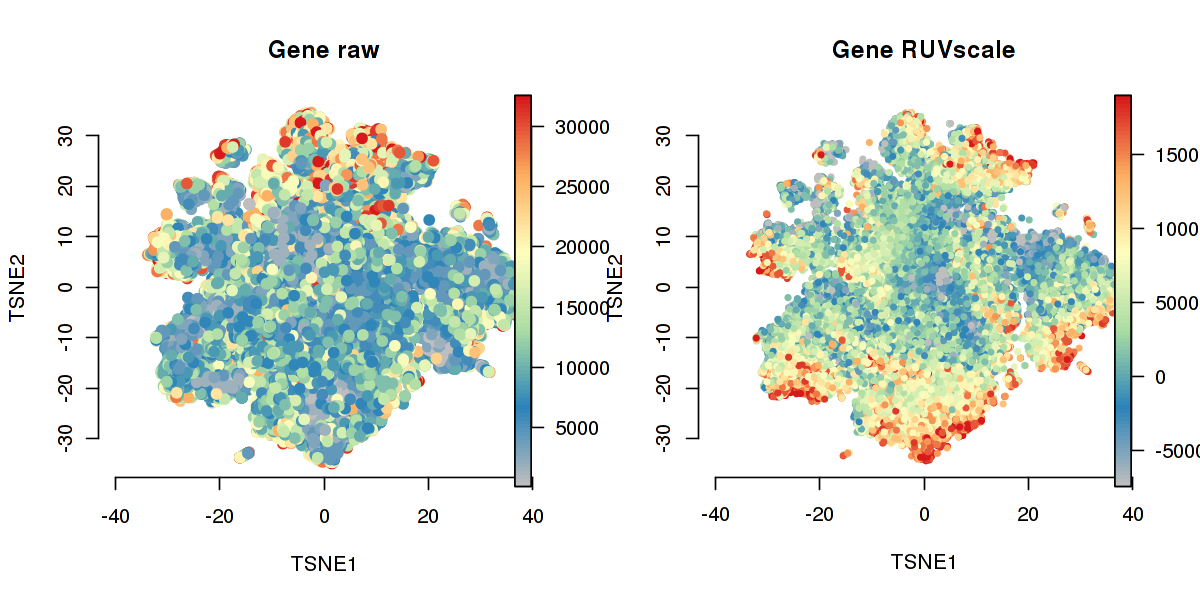

In [52]:
#find top variant gene / use mt gene and house keeping gene as control

taggene_posi=which(rownames(Exp_Seurat@raw.data) %in% c(taggene_hk,taggene_mt))

options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
val=colSums(Exp_Seurat@raw.data)
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(Exp_Seurat@dr$tsne@cell.embeddings,col=Genecols,pch=19,xlim=c(-40,40),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene raw")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

val=colSums(Exp_Seurat@scale.data)
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

plot(Exp_Seurat@dr$tsne@cell.embeddings,col=Genecols,pch=19,xlim=c(-40,40),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale",cex=0.5)
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

## gene expression heatmap

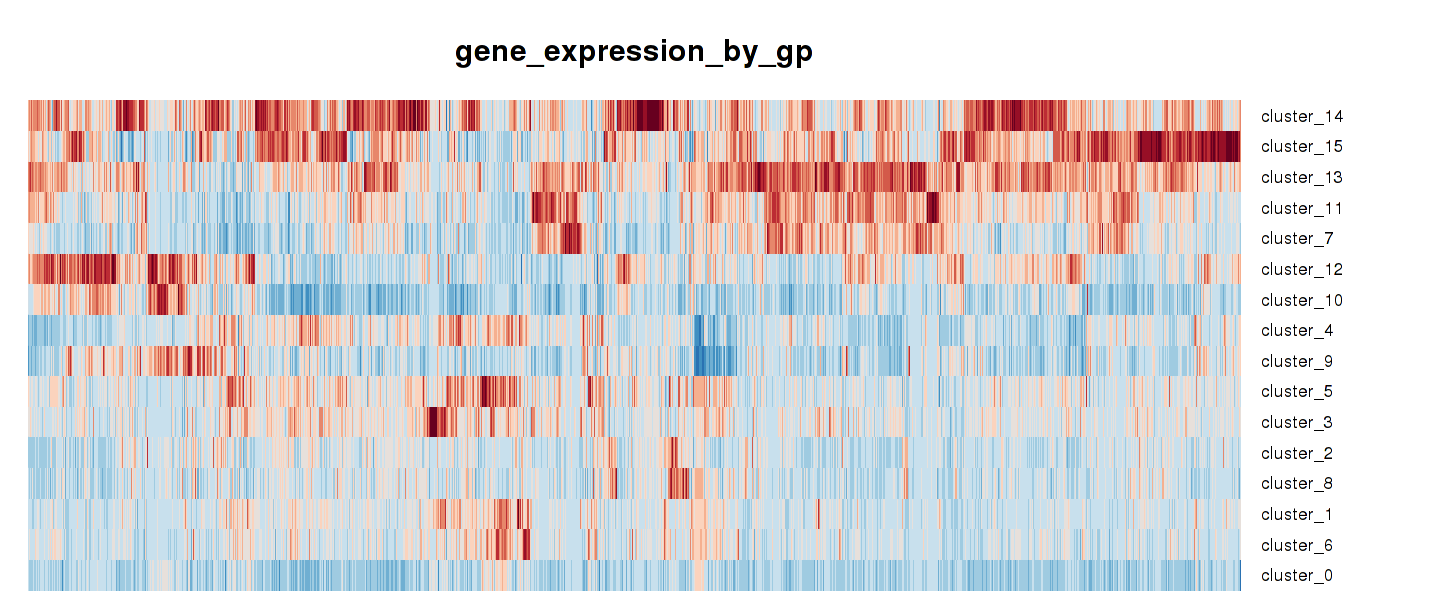

In [76]:
options(repr.plot.width=12, repr.plot.height=5)
heatmap.2(scale(ExpressionMat_by_gp),col=colorRampPalette(col2),
          lhei=c(1,5),lwid=c(0.1,5),margins = c(0.5,10),trace="none",density.info="none",dendrogram='none',Colv=T,Rowv=T,
          notecol="black",labCol=NULL,key=F,main="gene_expression_by_gp")

In [ ]:
options(repr.plot.width=12, repr.plot.height=12)
col2=rev(RColorBrewer::brewer.pal(10,"RdBu"))
cluster_col=colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))(length(levels(Exp_Seurat@ident)))
tagcell=sample(1:ncol(Exp_Seurat@scale.data),4000)
heatmap.2(t(Exp_Seurat@scale.data)[tagcell,HVG],col=colorRampPalette(col2),labRow=NULL,labCol=NULL,
          lhei=c(1,5),lwid=c(0.1,5),margins = c(0.5,2),trace="none",density.info="none",dendrogram='none',Colv=T,Rowv=T,
          notecol="black",key=F,main="gene_expression",RowSideColors=cluster_col[Exp_Seurat@ident[tagcell]])

## testing

In [15]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
t=list()
Exp_Seurat <- CreateSeuratObject(raw.data = t(ExpressionNormed[1:5000,]))
Exp_Seurat@meta.data$sample_gp <- sample_gp[1:5000]
Exp_Seurat@scale.data=Exp_Seurat@raw.data
Exp_Seurat@raw.data=as(t(ExpressionMat), "sparseMatrix")
Exp_Seurat <- RunPCA(object = Exp_Seurat, pc.genes = HVG[1:1000], pcs.compute = 50,do.print = F)

ptm <- proc.time()
Exp_Seurat <- RunTSNE(object = Exp_Seurat, dims.use = 1:25, do.fast = TRUE)
t[[1]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Y <- Rtsne::Rtsne(Exp_Seurat@dr$pca@cell.embeddings[1:5000,1:25],pca=F)
t[[2]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Y_fft <- fftRtsne(pca_allcell$x[1:5000,1:25],nthreads = 4);
#plot(Y_fft,col=iris_unique$Species,pch=19,cex=0.5) # Plot the result
t[[3]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Exp_Seuratfittsne <- RunTSNE(object = Exp_Seurat, reduction.use = "pca", dims.use = 1:25, tsne.method = "FIt-SNE",
                             nthreads = 4,reduction.name = "FItSNE", reduction.key = "FItSNE_",
                             fast_tsne_path = "/home/ahe/tools/FIt-SNE/bin/fast_tsne",max_iter = 2000)

t[[4]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

In [16]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
tt=list()
Exp_Seurat <- CreateSeuratObject(raw.data = t(ExpressionNormed[1:5000,]))
Exp_Seurat@meta.data$sample_gp <- sample_gp[1:5000]
Exp_Seurat@scale.data=Exp_Seurat@raw.data
Exp_Seurat@raw.data=as(t(ExpressionMat), "sparseMatrix")
Exp_Seurat <- RunPCA(object = Exp_Seurat, pc.genes = HVG[1:1000], pcs.compute = 50,do.print = F)

ptm <- proc.time()
Exp_Seurat <- RunTSNE(object = Exp_Seurat, dims.use = 1:25, do.fast = TRUE)
tt[[1]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Y <- Rtsne::Rtsne(Exp_Seurat@dr$pca@cell.embeddings[1:5000,1:25],pca=F)
tt[[2]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Y_fft <- fftRtsne(pca_allcell$x[1:5000,1:25],nthreads = 1);
#plot(Y_fft,col=iris_unique$Species,pch=19,cex=0.5) # Plot the result
tt[[3]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

ptm <- proc.time()
Exp_Seuratfittsne <- RunTSNE(object = Exp_Seurat, reduction.use = "pca", dims.use = 1:25, tsne.method = "FIt-SNE",
                             nthreads = 1,reduction.name = "FItSNE", reduction.key = "FItSNE_",
                             fast_tsne_path = "/home/ahe/tools/FIt-SNE/bin/fast_tsne",max_iter = 2000)

tt[[4]]=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))

In [22]:
method_names=c("Seurat_Rtsne_fast","Rtsne_noPCA","fftRtsne_4_thraeds","Seurat_ffRtsne_4_threads")
for(i in 1:4){
    message(paste(t[[i]][1],"hr",t[[i]][2],"min",t[[i]][3],"s\t",method_names[i]))
}
method_names=c("Seurat_Rtsne_fast","Rtsne_noPCA","fftRtsne_1_thraeds","Seurat_ffRtsne_1_threads")
for(i in 1:4){
    message(paste(tt[[i]][1],"hr",tt[[i]][2],"min",tt[[i]][3],"s\t",method_names[i]))
}


0 hr 1 min 8.08 s	 Seurat_Rtsne_fast
0 hr 1 min 3.53 s	 Rtsne_noPCA
0 hr 0 min 55.67 s	 fftRtsne_4_thraeds
0 hr 4 min 48.78 s	 Seurat_ffRtsne_4_threads
0 hr 1 min 20.28 s	 Seurat_Rtsne_fast
0 hr 1 min 10.02 s	 Rtsne_noPCA
0 hr 1 min 4.97 s	 fftRtsne_1_thraeds
0 hr 4 min 49.19 s	 Seurat_ffRtsne_1_threads


## xCell

In [ ]:
possible_celltype=c('aDC','Basophils','B-cells','CD4+ memory T-cells','CD4+ naive T-cells',
                    'CD4+ T-cells','CD4+ Tcm','CD4+ Tem','CD8+ naive T-cells','CD8+ T-cells','CD8+ Tcm','CD8+ Tem','cDC',
                    'Class-switched memory B-cells','CLP','CMP','DC','Eosinophils',
                    'GMP','iDC','Macrophages','Macrophages M1','Macrophages M2','Mast cells',
                    'Memory B-cells','Monocytes','naive B-cells','Neutrophils','NK cells','NKT','pDC',
                    'Plasma cells','pro B-cells','Tgd cells','Th1 cells','Th2 cells','Tregs')
xCellout=xCellAnalysis(t(ExpressionMat_by_gp))
xCellout=xCellout[rownames(xCellout) %in% possible_celltype,]

In [6]:
#rm the TRM
batchidx=gsub("/","",batchidx)
todrop=grep("TRM",batchidx)
if(length(todrop)>0){
    batchidx=batchidx[-todrop]
    todrop_posi=which(batch==todrop)
    batch=batch[-todrop_posi]
    batch=gp_name_replacing(batch,(1:max(batch))[-todrop],1:length(batchidx))
    ExpressionMat=ExpressionMat[-todrop_posi,]
    ExpressionMat_norm=ExpressionMat_norm[-todrop_posi,]
    PCAresult$x=PCAresult$x[-todrop_posi,]
    for(i in 1:length(rtsne_result2d)){
        rtsne_result2d[[i]]$Y=rtsne_result2d[[i]]$Y[-todrop_posi,]
    }
    for(j in 1:length(rtsne_result3d)){
        rtsne_result3d[[i]]$Y=rtsne_result3d[[i]]$Y[-todrop_posi,]
    }
}

ERROR: Error in gsub("/", "", batchidx): object 'batchidx' not found


In [8]:
possible_celltype=c('aDC','Basophils','B-cells','CD4+ memory T-cells','CD4+ naive T-cells',
                    'CD4+ T-cells','CD4+ Tcm','CD4+ Tem','CD8+ naive T-cells','CD8+ T-cells','CD8+ Tcm','CD8+ Tem','cDC',
                    'Class-switched memory B-cells','CLP','CMP','DC','Eosinophils',
                    'GMP','iDC','Macrophages','Macrophages M1','Macrophages M2','Mast cells',
                    'Memory B-cells','Monocytes','naive B-cells','Neutrophils','NK cells','NKT','pDC',
                    'Plasma cells','pro B-cells','Tgd cells','Th1 cells','Th2 cells','Tregs','HSC','MPP','MSC')

# Read in the data
x <- scan("/home/ahe/Analysis/genomeFiles/Celltype_signature.csv", what="", sep="\n")
# Separate elements by ,
x <- strsplit(x, "\\,")
reference_celltype_list=c()
reference_markerGenes_list=list()
for(i in 1:length(x)){
    celltype_id=gsub("_.*$","",x[[i]][1])
    if(celltype_id %in% possible_celltype){
        if(celltype_id %in% reference_celltype_list){
            reference_markerGenes_list[[celltype_id]]=union(reference_markerGenes_list[[celltype_id]],x[[i]][-1])
        }else{
            reference_markerGenes_list[[celltype_id]]=x[[i]][-1]
            reference_celltype_list=c(reference_celltype_list,celltype_id)
        }
    }
}

In [30]:
setdiff(reference_markerGenes_list$"CD4+ T-cells",reference_markerGenes_list$"CD8+ T-cells")
setdiff(reference_markerGenes_list$"CD8+ T-cells",reference_markerGenes_list$"CD4+ T-cells")

[1] "BAD"       "CD2"       "CD3G"      "CD5"       "CD28"      "CD40LG"   
  [7] "CCR4"      "CTLA4"     "GOLGA4"    "HMOX2"     "MGAT2"     "NFE2L2"   
 [13] "PLCL1"     "PPP2CA"    "SON"       "SUPV3L1"   "TRAF1"     "TSPYL1"   
 [19] "FBXO21"    "NUDCD3"    "LEPROTL1"  "ICOS"      "TRAT1"     "FOXP3"    
 [25] "USP36"     "DDX31"     "RIC3"      "SLTM"      "HIPK1"     "ATXN7L1"  
 [31] "CD3E"      "CD6"       "DNAH6"     "HNRNPU"    "MBNL1"     "TPP2"     
 [37] "UBP1"      "ZAP70"     "OFD1"      "HERC1"     "RBM19"     "DLEC1"    
 [43] "CCR9"      "ZCCHC11"   "PHF3"      "TOR1AIP1"  "IL21R"     "WBP11"    
 [49] "THAP1"     "MKL1"      "RBM25"     "RSRC2"     "ZXDC"      "HAUS3"    
 [55] "C14orf169" "ARID5B"    "TOE1"      "TUBGCP5"   "SNX19"     "ITK"      
 [61] "CUBN"      "SNPH"      "SPEG"      "NOL9"      "ANKRD55"   "OBSCN"    
 [67] "CHMP7"     "PPWD1"     "KRIT1"     "CCNT2"     "CD4"       "TNFSF8"   
 [73] "CCR8"      "DDX5"      "GPR183"    "EZH1"      "FCN1"      "GP5"      
 [79] "ITIH4"     "PABPC3"    "POU6F1"    "PPM1B"     "RXRG"      "ATXN7"    
 [85] "TPT1"      "NR2C1"     "NCK2"      "CDC14A"    "FUBP1"     "UBA3"     
 [91] "SGSM2"     "HMGN4"     "CA5B"      "MORC2"     "SACM1L"    "USP33"    
 [97] "MTO1"      "SIT1"      "PNMA3"     "CRLF3"     "UBASH3A"   "LAX1"     
[103] "TUG1"      "PRPF38B"   "ASXL2"     "THUMPD1"   "ARHGAP15"  "ALG13"    
[109] "CBLL1"     "TRMT2B"    "TRIM46"    "FBXO11"    "NFATC2IP"  "TMEM123"  
[115] "ZFC3H1"    "GIMAP6"    "CCR2"      "ABCD2"     "TNFRSF4"   "TOMM20"   
[121] "GPR171"    "ZNF335"    "ZNHIT6"

[1] "CD8A"    "CD8B"    "IL16"    "MMP19"   "NFKB1"   "NPAT"    "PCNT"   
 [8] "PFN2"    "PURA"    "RING1"   "MTRF1"   "TSPAN32" "CEPT1"   "RBM34"  
[15] "CLUAP1"  "CBY1"    "POP5"    "YLPM1"   "CRTAM"   "CIAPIN1" "CA6"    
[22] "CTSW"    "FKTN"    "NDUFS2"  "S100B"   "ZNF200"  "MYOM1"   "SDCCAG3"
[29] "BTN2A1"  "COG2"    "UTP20"   "DPP8"    "CCDC25"  "NKRF"    "GGNBP2" 
[36] "WDR82"   "NDFIP1"  "TMEM41B" "NAA16"   "CASP8"   "GZMK"    "PTGDR"  
[43] "SLC1A7"  "KLRG1"   "NPRL2"   "DHX15"   "GZMM"    "HNRNPL"  "KRT2"   
[50] "PRL"     "RASA2"   "RPL37A"  "ZNF154"  "PRPF4B"  "MED17"   "HNRNPA0"
[57] "SHANK1"  "ZNF639"  "GJC2"    "IRF3"    "TBCC"    "SDAD1"   "FTO"    
[64] "RNF113A" "CD160"   "COPZ1"   "MKRN2"   "UBE2Q1"  "C7orf26" "EML3"   
[71] "CX3CR1"  "EEF1D"   "GZMH"    "KLRB1"   "LAIR2"   "PTPN4"   "FBXW4"  
[78] "RWDD3"   "TOMM7"   "FAM134C" "CCDC53"

In [ ]:
markerGenes_list=list()
match_num_matrix=matrix(0,length(levels(Exp_Seurat@ident)),length(reference_markerGenes_list))
match_geneid_matrix=matrix("",length(levels(Exp_Seurat@ident)),length(reference_markerGenes_list))
colnames(match_num_matrix)=names(reference_markerGenes_list)
rownames(match_num_matrix)=levels(Exp_Seurat@ident)
colnames(match_geneid_matrix)=names(reference_markerGenes_list)
rownames(match_geneid_matrix)=levels(Exp_Seurat@ident)
for(i in 1:length(levels(Exp_Seurat@ident))){
    markerGenes_list[[i]]=marker_genesgene[marker_genes$cluster==i-1]
    for(j in 1:length(reference_celltype_list)){
        match_num_matrix[i,j]=sum(markerGenes_list[[i]] %in% reference_markerGenes_list[[j]])
        match_geneid_matrix[i,j]=paste0(intersect(markerGenes_list[[i]],reference_markerGenes_list[[j]]),collapse = ", ")
    }
}